## Studying Growth Instability

This code lets us explore how QLC-2 solutions vary with the following parameters:
- $D_{surf}$ (surface diffusion coefficient of the QLL)
- $\nu_{kin}$ (rate at which water vapor strikes the surface)
- $\sigma_r$ (reduction in supersaturation at facet centers relative to corners)
- $L$ (crystal dimension)
- $\tau_{eq}$, $\sigma_o$, $\overline N$, and $N^*$ (all atomistic-level characteristics of the ice surface)

These are specified as small departures from a baseline scenario, taken from *Parameter Baseline*, which tries to come up with a self-consistent set of parameters at given values of:
- $T$ (ambient temperature)
- $P$ (ambient air pressure)
- $\sigma_{I,far}$ and $x_{far}$ (super/subsaturation of water vapor far from the crystal, and distance from the crystal at which $\sigma_{I,far}$ is specified)

In [11]:
import numpy as np
import matplotlib.pylab as plt
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from importlib import reload
from scipy import optimize
from matplotlib import rcParams

import sys
sys.path.append('..')
import QLCstuff as QLC

In [12]:
%matplotlib inline
ticklabelsize = 15
linewidth = 1
fontsize = 15
titlefontsize = 8
color = 'k'
markersize = 10

# Preferred units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'
temperature_unit = 'kelvin'

### These are parameters we're not planning on varying

In [13]:
# Properties of the QLL
Nbar = 1.0
Nstar = .9/(2*np.pi)
print('Nbar =', Nbar)
print('Nstar =', Nstar)

# The equilibration time
tau_eq = AssignQuantity(1,'microsecond')
print('tau_eq =',tau_eq)

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = 0.2
print('sigma0 =',sigma0)
sigma0factor = 1.1

# Thickness of monolayers
nmpermonolayer = h_pr = AssignQuantity(0.389,'nanometer') # Prismatic facet as used in Neshyba et al 2016
print('nmpermonolayer =', nmpermonolayer)
h_pr.ito('micrometer')
h_pyfactor = 1 # How the pyramidal layer thickness compares to the prismatic

# Microfacet parameters
theta = AssignQuantity(28, 'degrees')
beta_trans_factor = 4
Nstarfactor = 0.9

# Other baseline values
D_baseline = AssignQuantity(3.65e-04,'micrometer^2/microsecond'); print('D_baseline =',D_baseline)
nu_kin_baseline = AssignQuantity(105,'micrometer/second'); print('nu_kin_baseline =', nu_kin_baseline)
L_baseline = AssignQuantity(30,'micrometer'); print('L_baseline =', L_baseline)

Nbar = 1.0
Nstar = 0.1432394487827058
tau_eq = 1 microsecond
sigma0 = 0.2
nmpermonolayer = 0.389 nanometer
D_baseline = 0.000365 micrometer ** 2 / microsecond
nu_kin_baseline = 105 micrometer / second
L_baseline = 30 micrometer


### Parameters we might vary

In [14]:
# Defining scenarios
# sigmaI_corner_baseline = AssignQuantity(0.244,'dimensionless') 
sigmaI_corner_baseline = AssignQuantity(0.22,'dimensionless') 
c_r_percent_baseline = AssignQuantity(1.068,'dimensionless')
c_r_baseline = c_r_percent_baseline/100
tau_eq_baseline = AssignQuantity(1.0,'microsecond')

odemethod = 'RK23' # Explicit Runge-Kutta  
odemethod = 'DOP853' # Explicit Runge-Kutta (order 8)
odemethod = 'LSODA' # Adams/BDF method 
odemethod = 'Radau' # Implicit Runge-Kutta of the Radau IIA family of order 5 (takes ~200x explicit methods)
odemethod = 'RK45' # Explicit Runge-Kutta
# odemethod = 'BDF' # Implicit multi-step variable-order (1 to 5) method (takes ~100x explicit methods)

In [15]:
parameter_names = ['L', 'D', 'nu_kin', 'sigmaI_corner', 'c_r(%)']; print(parameter_names)
result_names = ['g_ice_QLC', 'lambda_average', 'alpha']; print(result_names)

['L', 'D', 'nu_kin', 'sigmaI_corner', 'c_r(%)']
['g_ice_QLC', 'lambda_average', 'alpha']


### Make a list of parameter sets

In [16]:
parameterlist_mag = []

# Baseline
# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
#      sigmaI_corner_baseline, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
#      0.215, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, 105, 
#      0.21, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
#      0.208, c_r_percent_baseline.magnitude, 5])

parameterlist_mag.append(
    [L_baseline.magnitude, D_baseline.magnitude, 120, 
     0.215, c_r_percent_baseline.magnitude, 5])

# # Varying the diffusion coefficient
# parameterlist_mag.append(
#     [L_baseline.magnitude, 0.0002, nu_kin_baseline.magnitude, 
#      sigmaI_corner_baseline, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

# # Varying the freezing time constant
# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude,  
#      sigmaI_corner_baseline, c_r_percent_baseline.magnitude, 1.1])

# # Varying the kinetic velocity 
# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, 110, 
#      sigmaI_corner_baseline, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

# # Baseline
# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
#      sigmaI_corner_baseline, 1.0, tau_eq_baseline.magnitude])

print(parameterlist_mag)

[[30, 0.000365, 120, 0.215, 1.068, 5]]


### Run the list

L = 30 micrometer
D =  0.000365 micrometer ** 2 / microsecond
nu_kin =  120 micrometer / second
nu_kin_mlyperus = 0.30848329048843187 / microsecond
sigmaI_corner = 0.215 dimensionless
c_r_percent = 1.068 dimensionless
odemethod = RK45
nx (crystal) = 320
Spacing of points on the ice surface = 0.18808777429467227 micrometer
Estimating times for the trajectory run
   time (est) =  47.781848256749655 millisecond
   time (used) =  4000 millisecond
   dt = 8016.032064128257 microsecond
10 % elapsed time is 1.340 minutes
20 % elapsed time is 2.671 minutes
30 % elapsed time is 3.945 minutes
40 % elapsed time is 5.245 minutes
50 % elapsed time is 6.545 minutes
60 % elapsed time is 7.841 minutes
70 % elapsed time is 9.137 minutes
80 % elapsed time is 10.396 minutes
90 % elapsed time is 11.636 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']

/Users/nesh/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


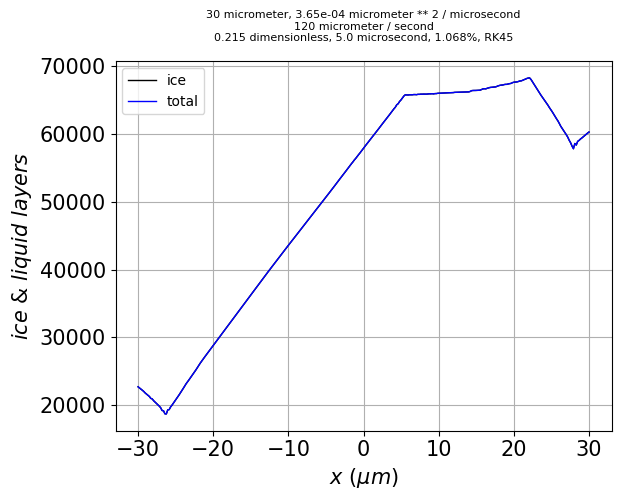

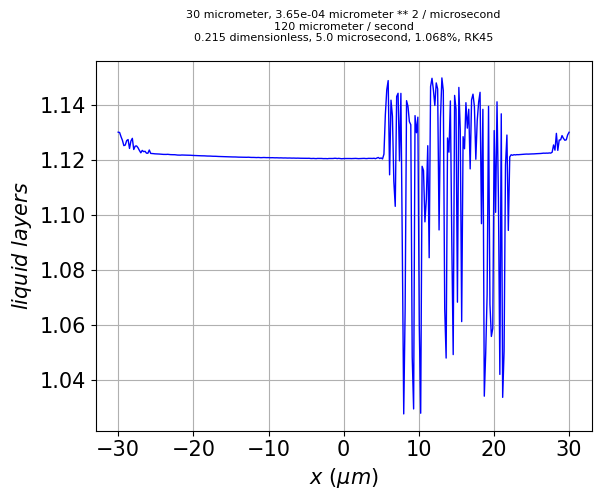

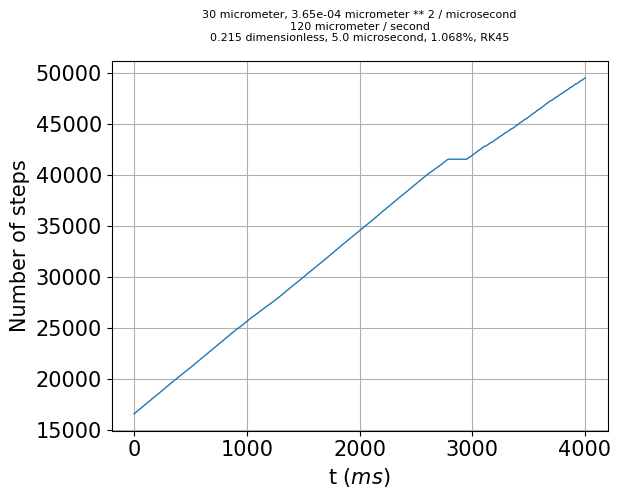

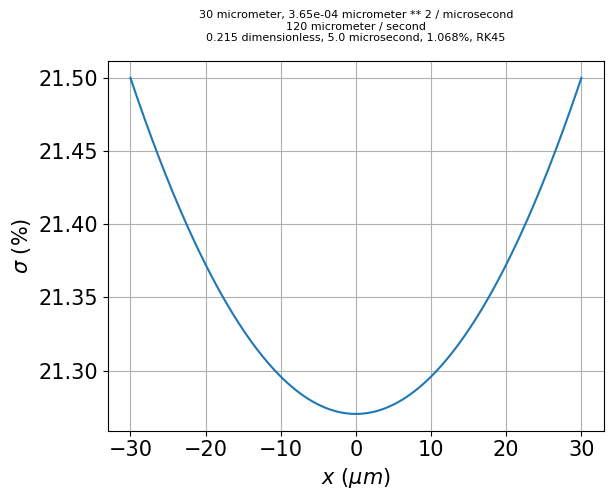

In [17]:
parameterlist = []
resultslist = []
icount = 0
for parameter_magnitudes in parameterlist_mag:
    
    # Counter 
    icount += 1

    # Size of the box
    L = AssignQuantity(parameter_magnitudes[0],'micrometer') 
    print('L =', L)

    # Surface diffusion coefficient
    D = AssignQuantity(parameter_magnitudes[1],'micrometer^2/microsecond') 
    print('D = ',D)

    # Kinetic velocity
    nu_kin = AssignQuantity(parameter_magnitudes[2],'micrometer / second')
    print('nu_kin = ',nu_kin)
    nu_kin_mlyperus = nu_kin/nmpermonolayer
    nu_kin_mlyperus.ito('1/microsecond')
    print('nu_kin_mlyperus =', nu_kin_mlyperus)

    # Supersaturation at the corner
    sigmaI_corner = AssignQuantity(parameter_magnitudes[3],'dimensionless')
    print('sigmaI_corner =', sigmaI_corner)
    
    # Supersaturation at the corner
    c_r_percent = AssignQuantity(parameter_magnitudes[4],'dimensionless')
    print('c_r_percent =', c_r_percent)
    c_r = c_r_percent/100
    
    # Just reporting the integration method
    print('odemethod =', odemethod)

    # Freezing time constant
    tau_eq = AssignQuantity(parameter_magnitudes[5],'microsecond')

    # Number of points on the ice surface
    Lx_reference = AssignQuantity(75,'micrometer')
    nx_crystal = int(800*L/Lx_reference) # 
    if (nx_crystal % 2 == 1): nx_crystal -= 1
    print('nx (crystal) =', nx_crystal)
    x_QLC = np.linspace(-L,L,nx_crystal)
    
    # supersaturation over the ice surface
    sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)

    # Scaled version of the diffusion coefficient
    deltax = x_QLC[1]-x_QLC[0]
    print('Spacing of points on the ice surface =', deltax)
    Doverdeltax2 = D/deltax**2

    # Estimating/deciding on how long to make the integration
    print('Estimating times for the trajectory run')
    L_reference = AssignQuantity(1,'millimeter')
    time_reference = AssignQuantity(1,'millisecond')
    tlast_estimated = (L*L_reference/D*time_reference)**.5 / 6
    tlast_estimated.ito('millisecond'); print('   time (est) = ', tlast_estimated)
    tlast = tlast_estimated # Use this line to keep the estimated time
    tlast = AssignQuantity(4000,'millisecond') # Use this line to override the estimated time
    print('   time (used) = ',tlast.to('msec'))
    tlast.ito('microsecond')

    # Number of time steps to report back
    ntimes = 500
    tkeep_1Darr = np.linspace(0,tlast,ntimes)
    print('   dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

    # Initialize as a pre-equilibrated layer of liquid over ice
#     Ntot_init_1D = np.ones(nx_crystal)
#     NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)
    Ntot_init_1D = Ntotkeep_1D[-1,:]
    NQLL_init_1D = NQLLkeep_1D[-1,:]

    title_params = \
        "{:.0f}".format(L.magnitude)+' '+str(L.units)+\
        ", "+np.format_float_scientific(D.magnitude,precision=2)+" "+str(D.units)+\
        "\n"+\
        "{:.0f}".format(nu_kin.magnitude)+' '+str(nu_kin.units)+\
        "\n"+\
        "{:.3f}".format(sigmaI_corner.magnitude)+' '+str(sigmaI_corner.units)+\
        ", "+"{:.1f}".format(tau_eq.magnitude)+' '+str(tau_eq.units)+\
        ", "+"{:.3f}".format(c_r_percent.magnitude)+'%'+\
        ", "+odemethod+\
        "\n"

    # Solve the 1-D problem
    Ntotkeep_1D, NQLLkeep_1D = QLC.run_pypr(\
                    NQLL_init_1D, Ntot_init_1D, tkeep_1Darr,\
                    Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, \
                    theta, beta_trans_factor, Nstarfactor, h_pr, h_pyfactor, sigma0factor,\
                    sigmaI_QLC, x_QLC,
                    AssignQuantity,\
                    verbose=0, odemethod=odemethod)
    Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

#   Report
    g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,nmpermonolayer, \
        graphics=True,title_params=title_params)
    print('tau =', tau_eq)
    print('c_r(%) =', c_r_percent)
    print('final g_ice_QLC =',g_ice_QLC)
    alpha = g_ice_QLC/(sigmaI_corner*nu_kin)
    alpha = AssignQuantity(alpha,'dimensionless')
    print('alpha relative to sigmaI_corner =',alpha)

    plt.figure()
    plt.plot(x_QLC,sigmaI_QLC*100)
    plt.grid(True)
    plt.xlabel('$x \ (\mu m)$',fontsize=fontsize)
    plt.ylabel('$\sigma \ (\%)$',fontsize=fontsize)
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.title(title_params,fontsize=titlefontsize)
    
    parameters = [L,D,nu_kin,sigmaI_corner,c_r_percent,tau_eq]
    parameterlist.append(parameters)
    print('Done with scenario ', icount,' out of ', len(parameterlist_mag))
    print('--------------------')

/Users/nesh/Documents/Repositories/icecontinuum/2024 - Filippo/../QLCstuff.py:419: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


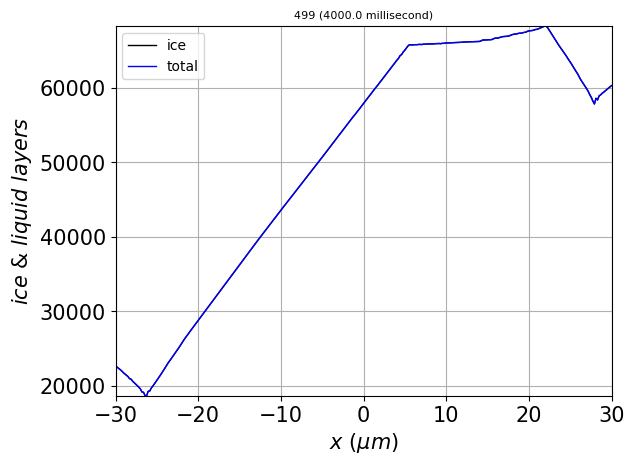

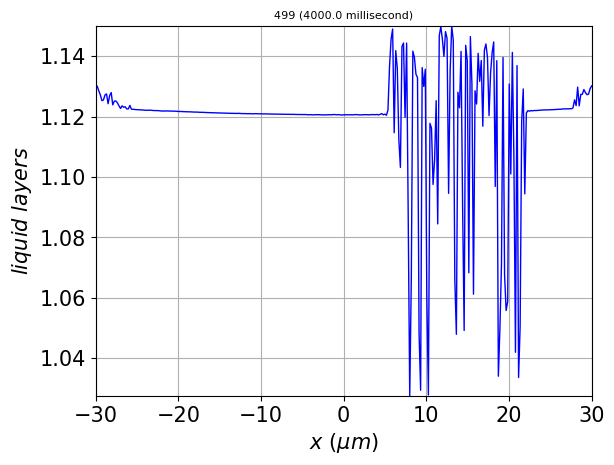

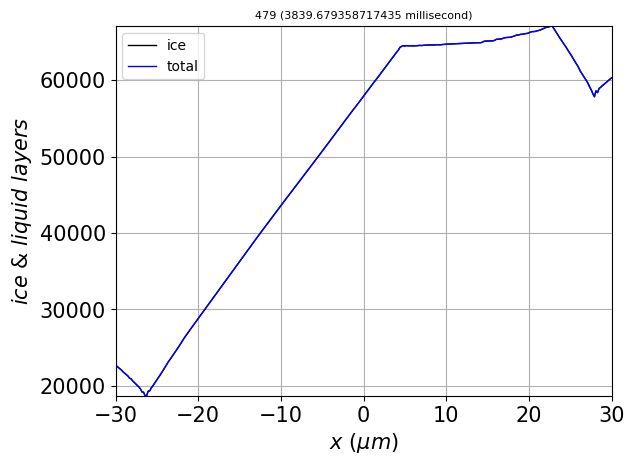

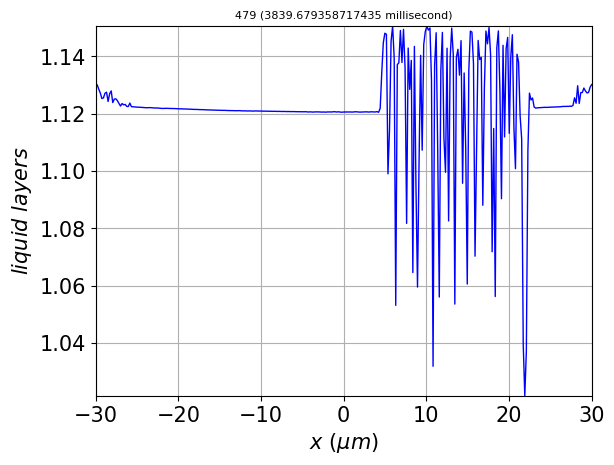

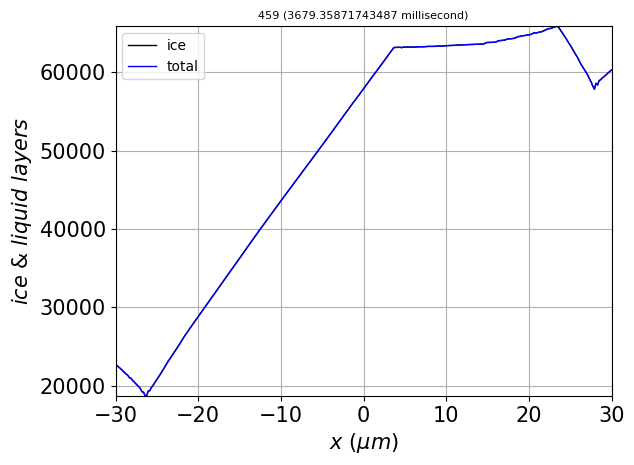

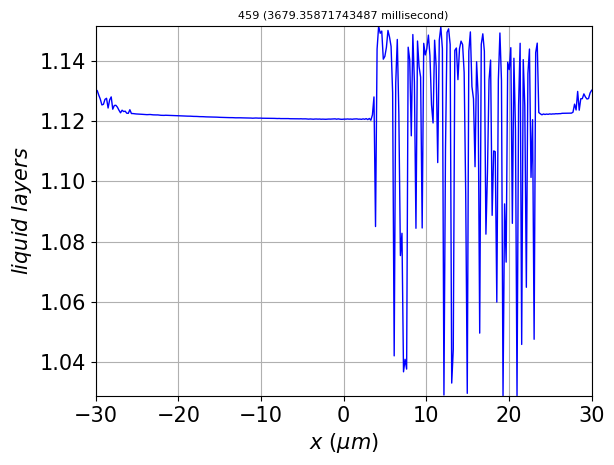

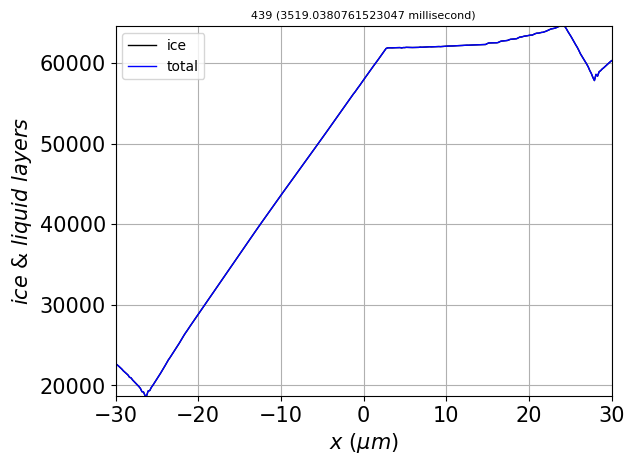

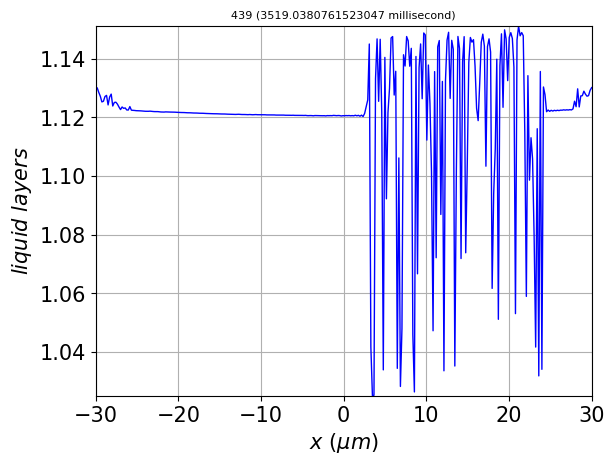

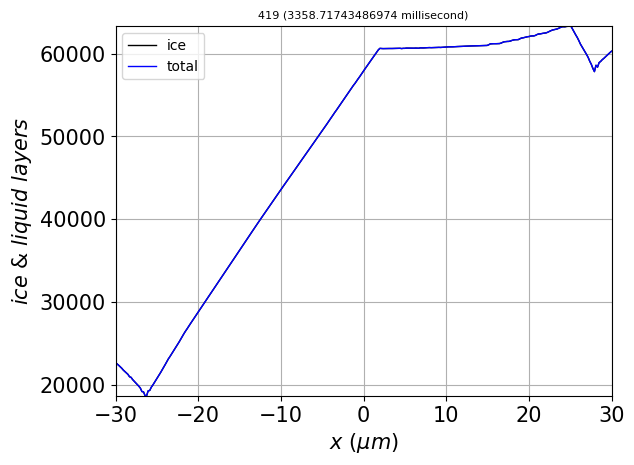

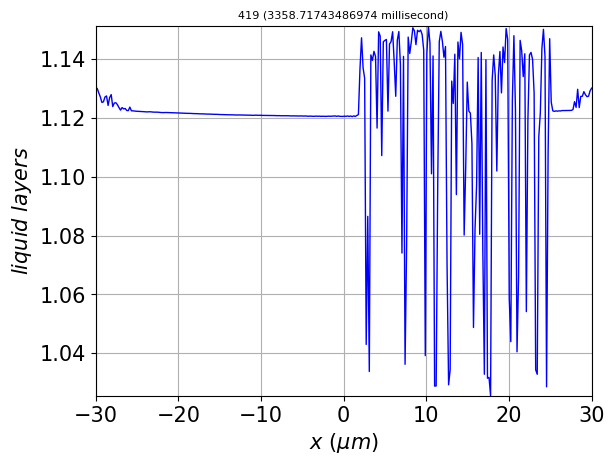

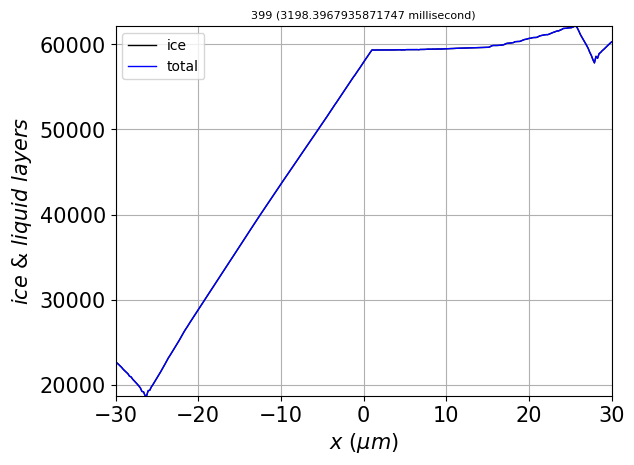

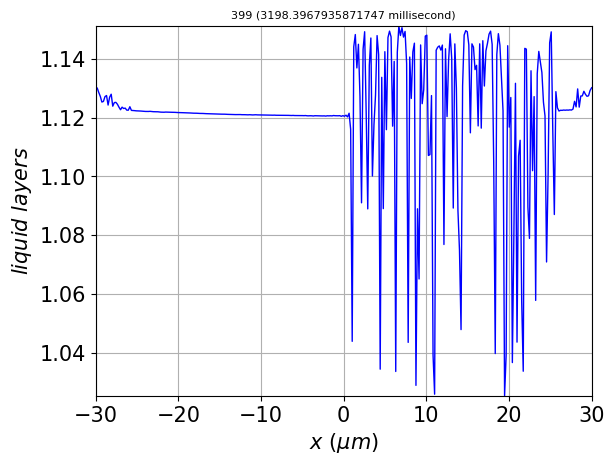

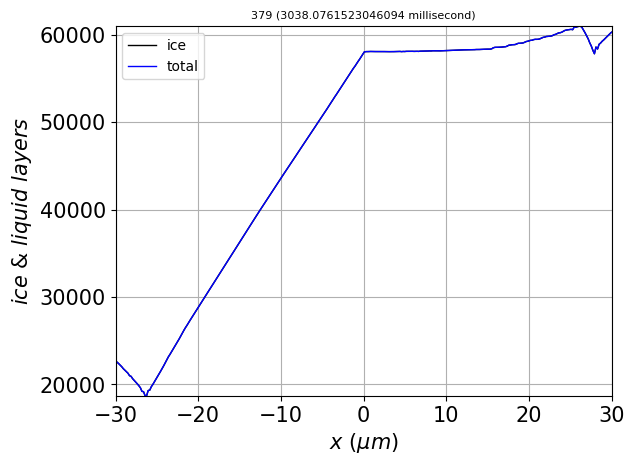

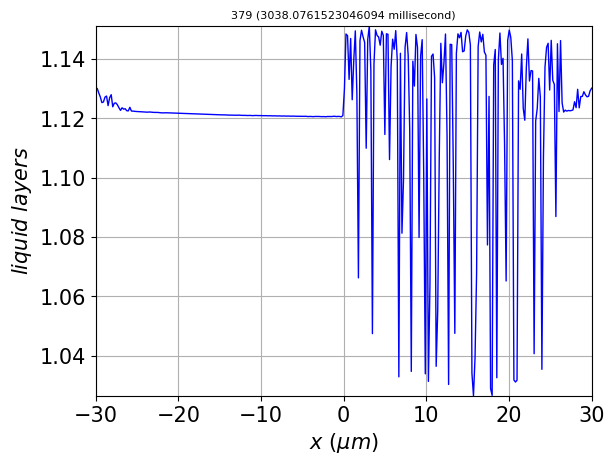

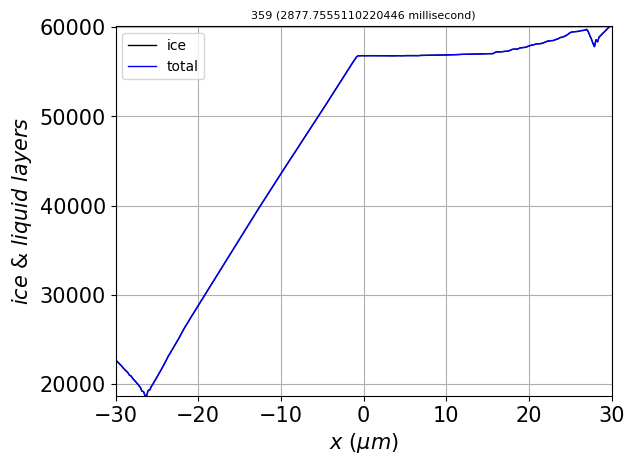

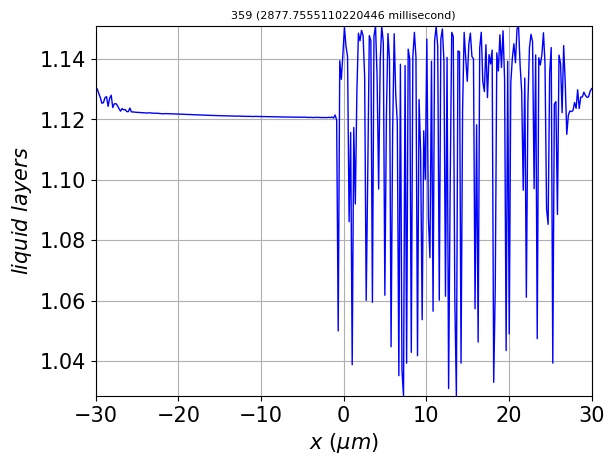

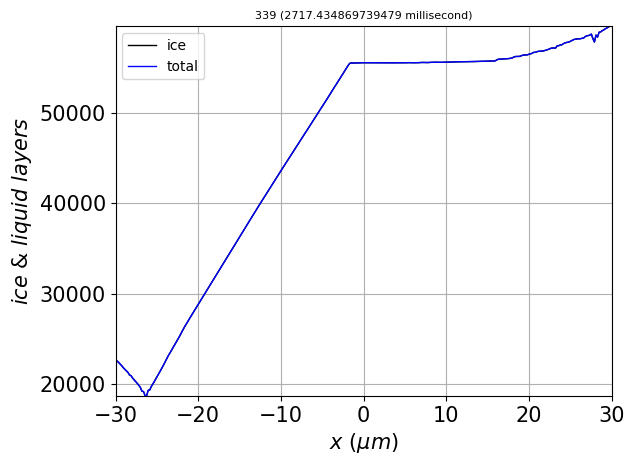

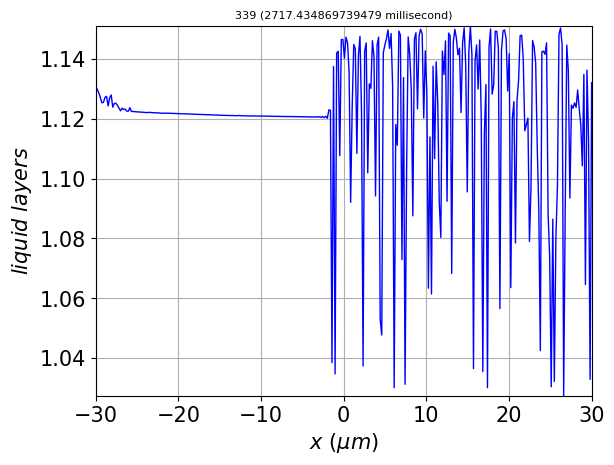

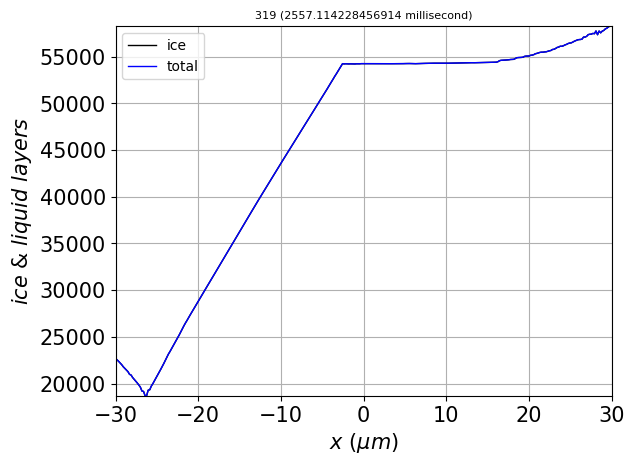

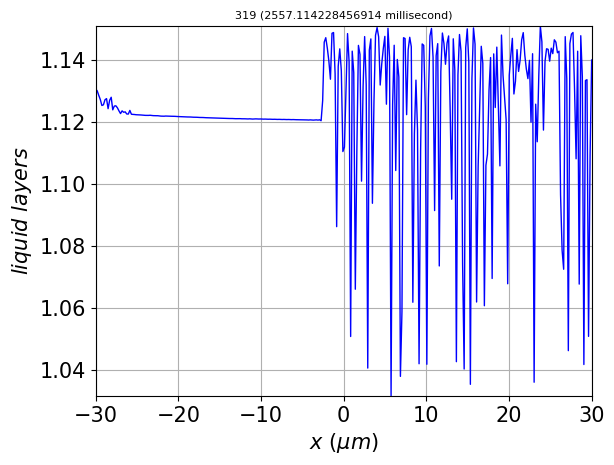

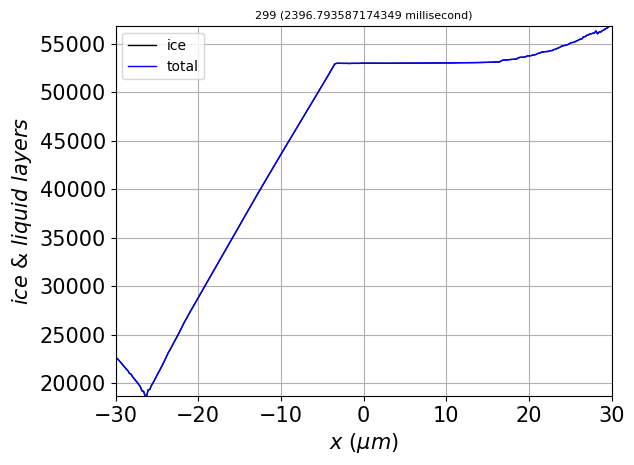

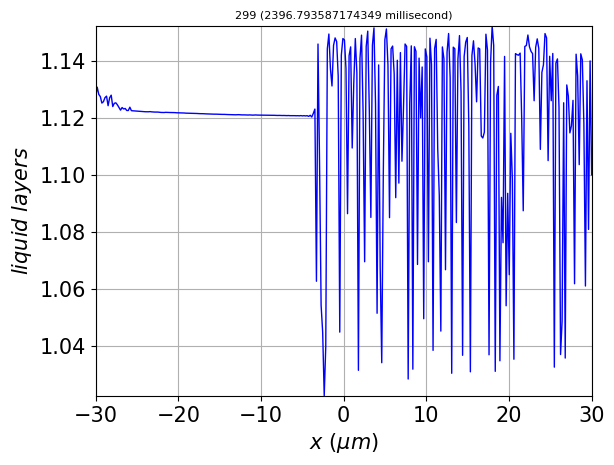

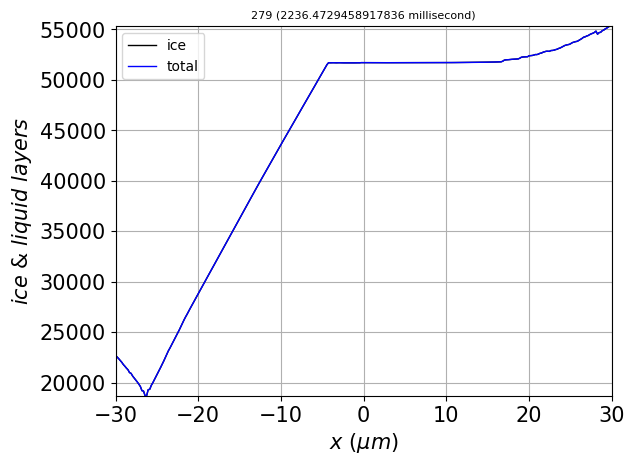

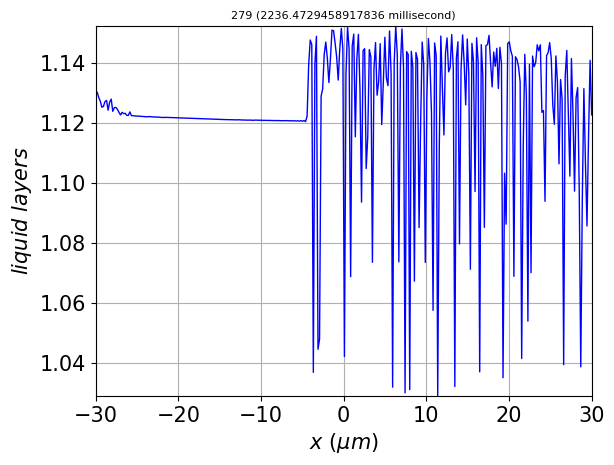

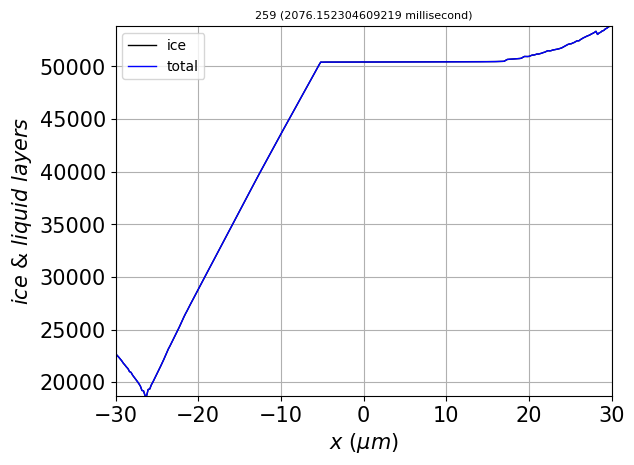

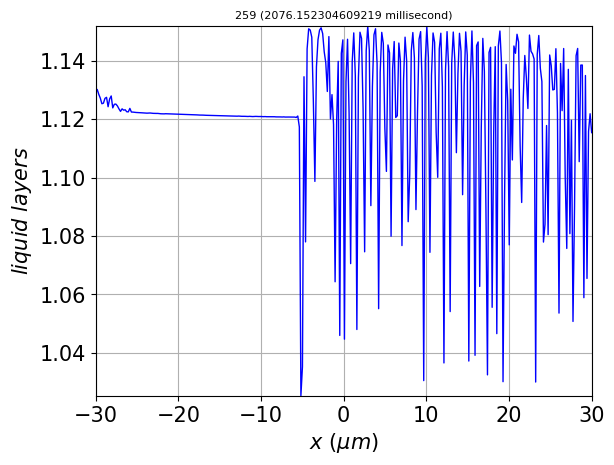

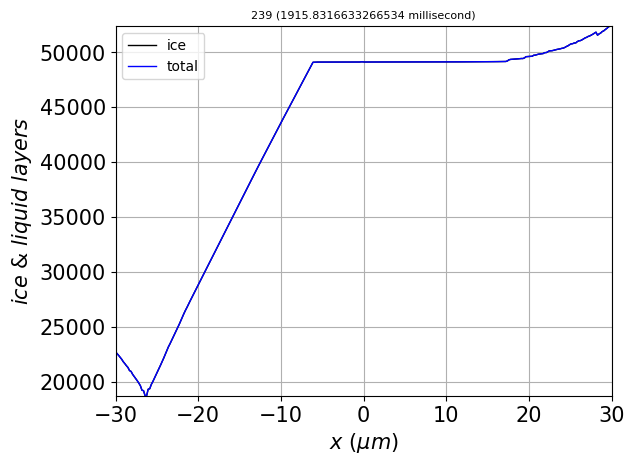

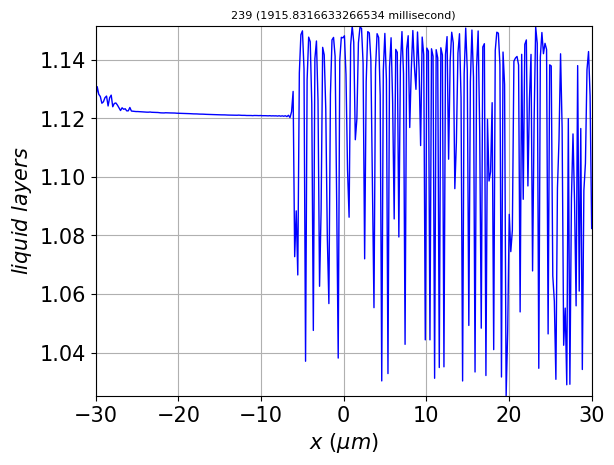

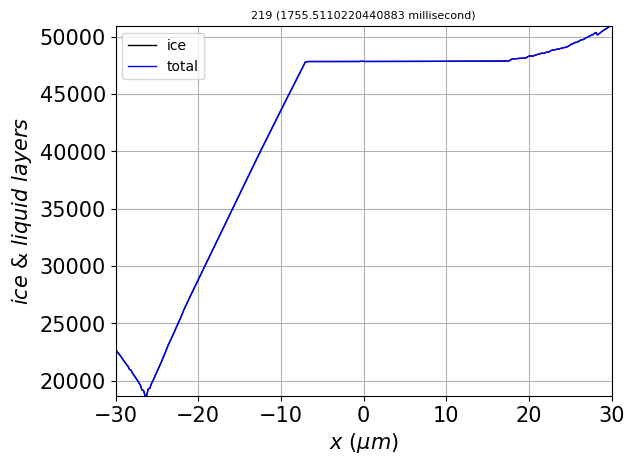

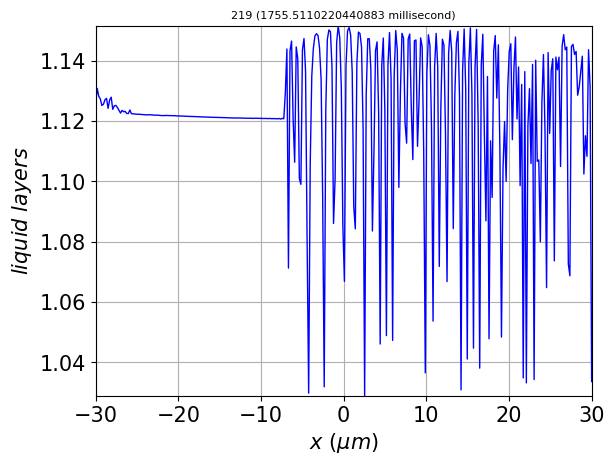

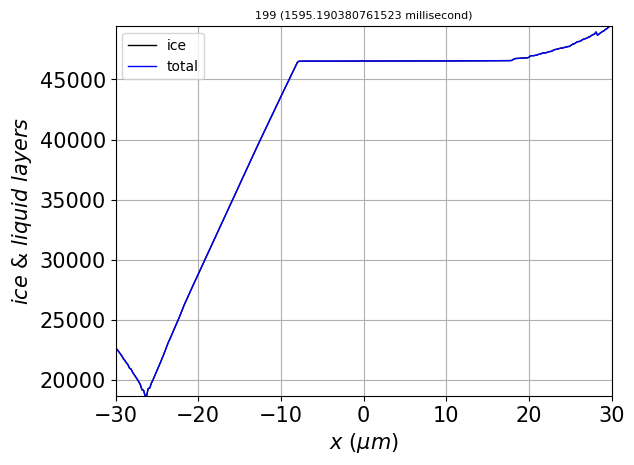

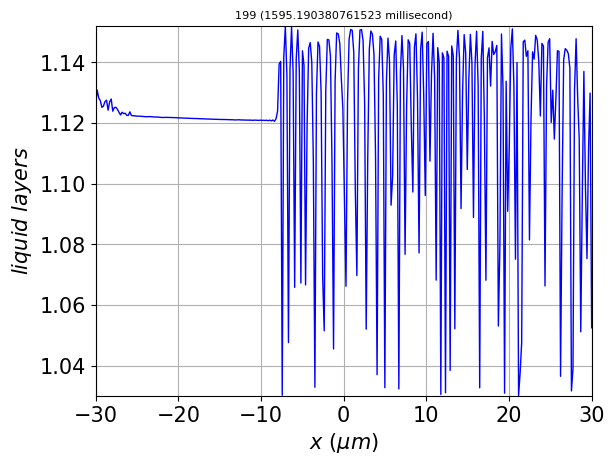

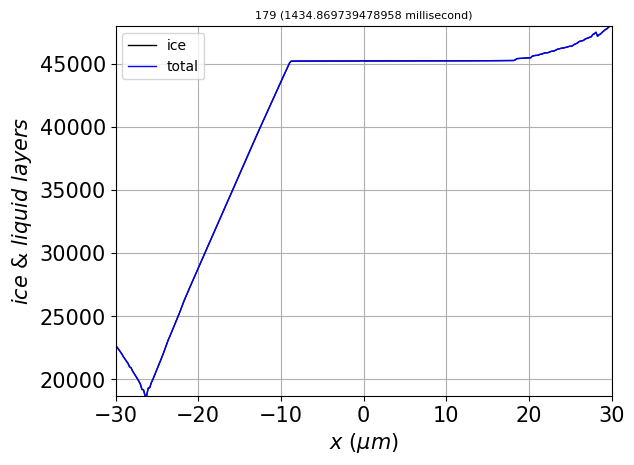

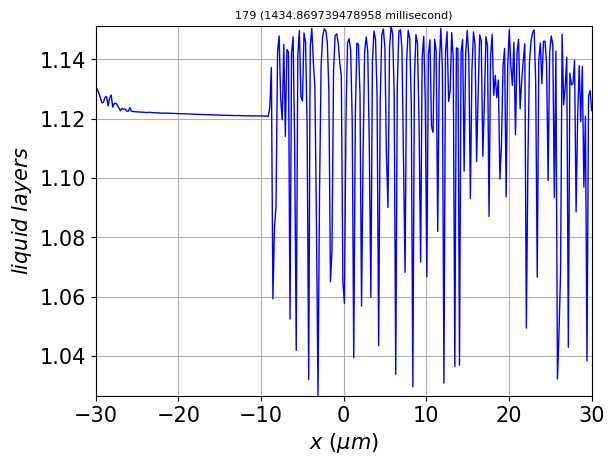

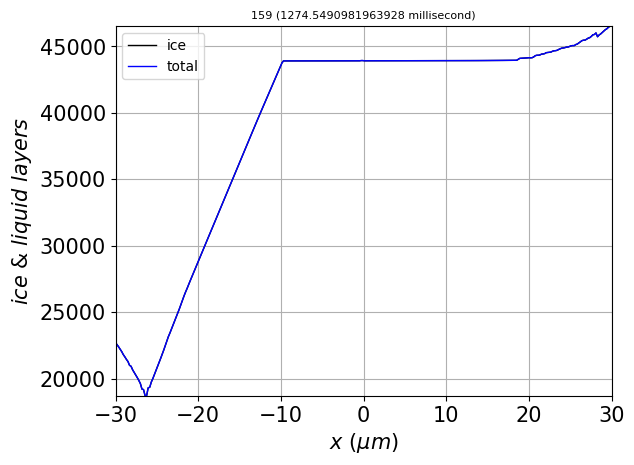

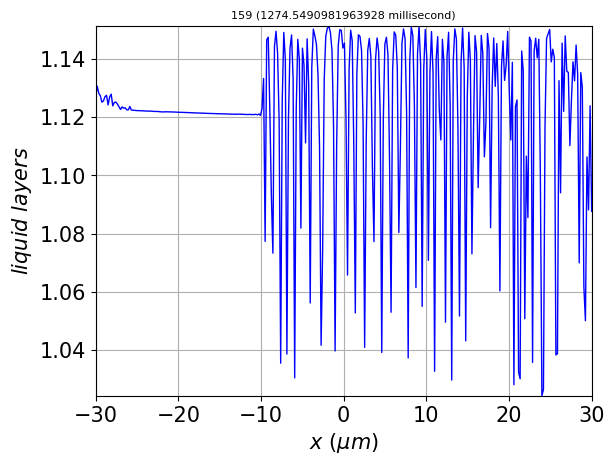

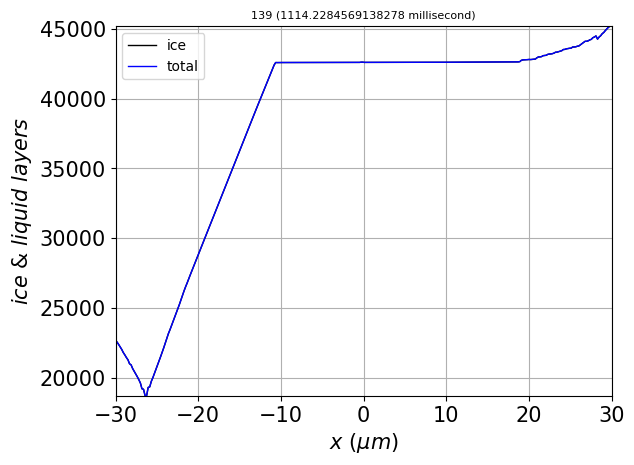

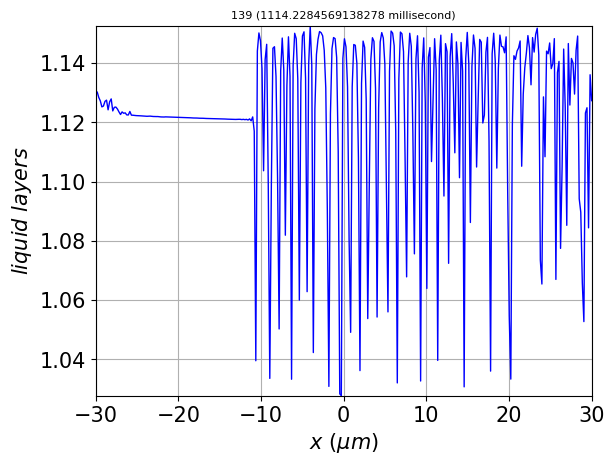

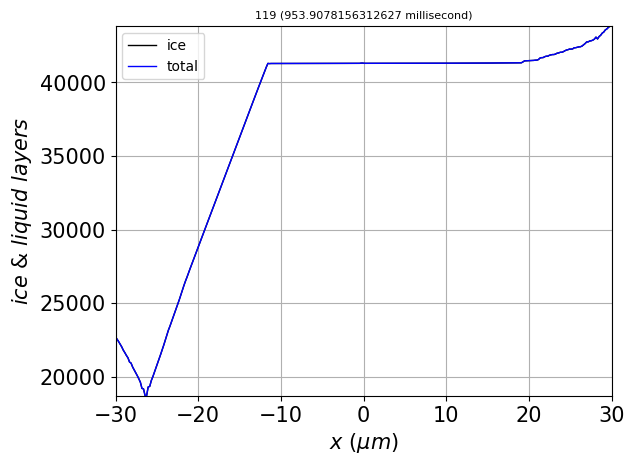

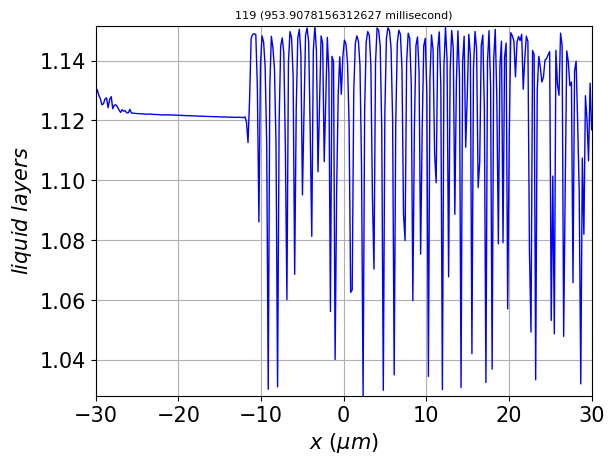

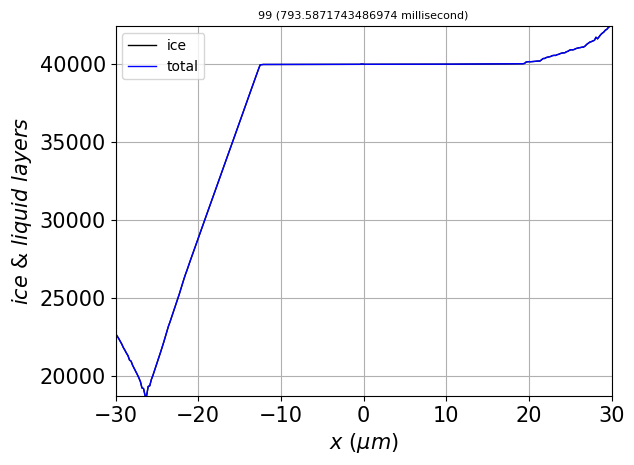

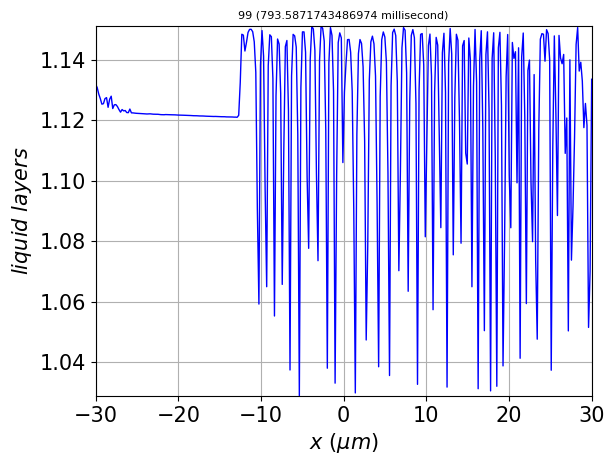

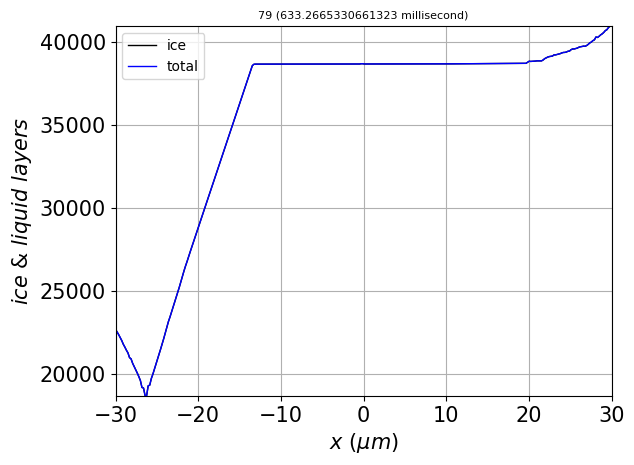

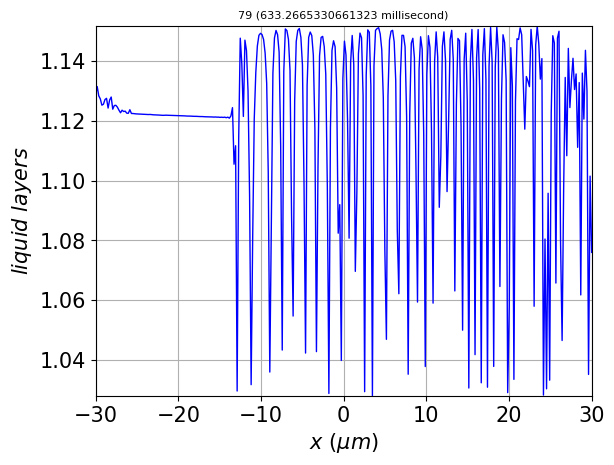

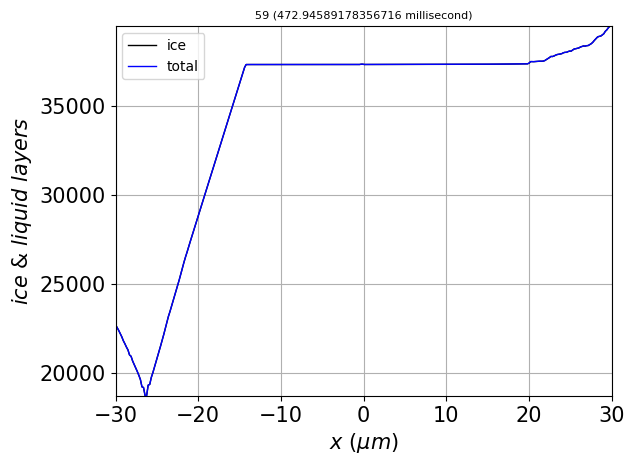

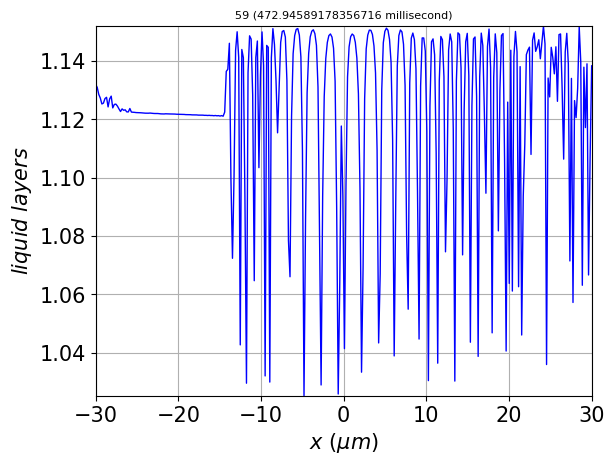

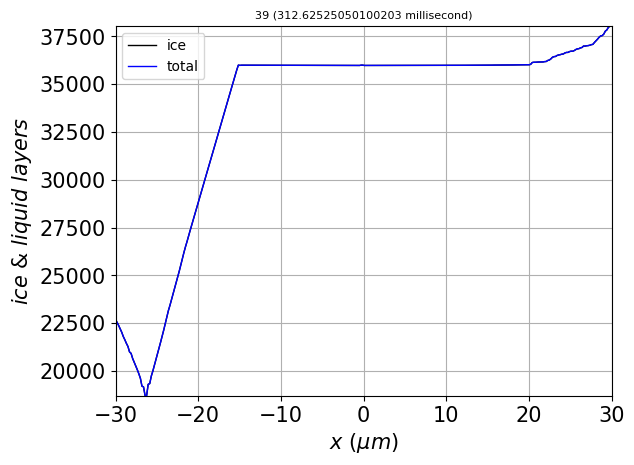

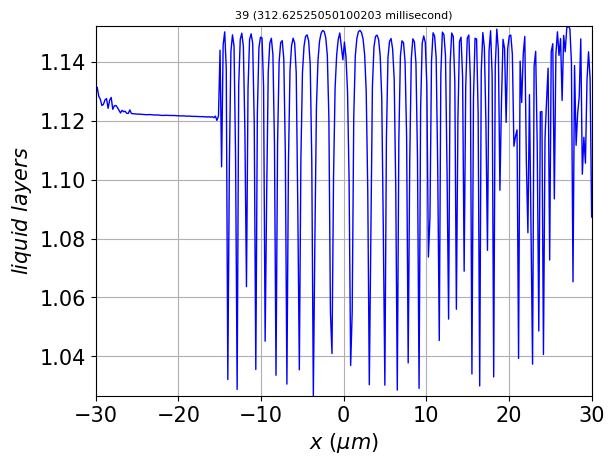

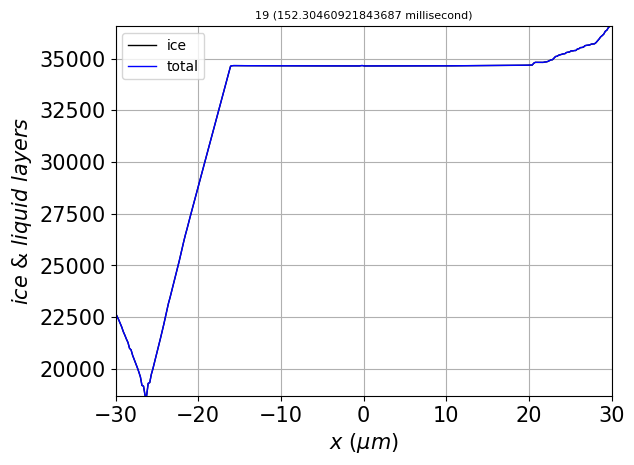

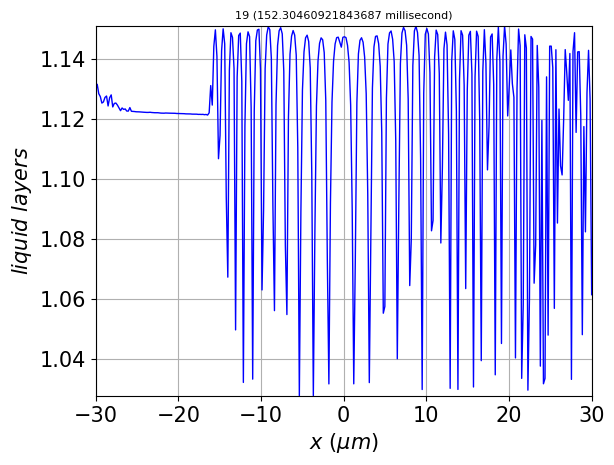

In [18]:
# Check out intermediate values
for itime in range(ntimes-1,0,-20):
    title_params = str(itime)+' ('+str(tkeep_1Darr[itime].to('millisecond'))+')'
    g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,nmpermonolayer, \
        graphics=True,tgraphics=False,title_params=title_params,itime=itime, \
        xlim=[-30,30])

Probing itime = -1
Probing time = 4000.0 millisecond
beta_trans = 0.2493280028431807 dimensionless
delta_beta 0.06233200071079518 dimensionless
0.12891550390443524


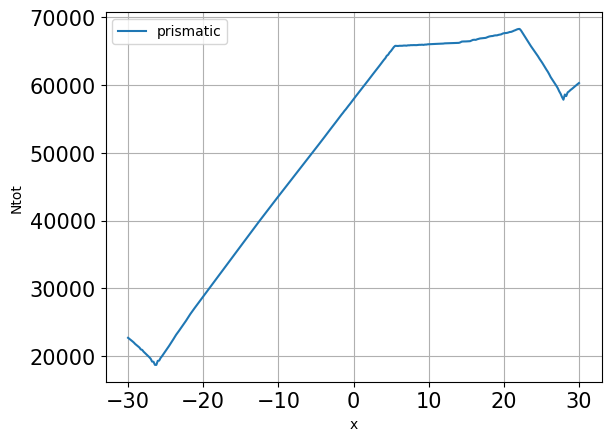

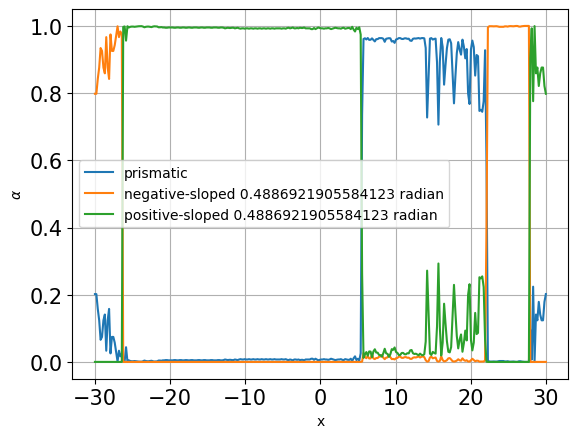

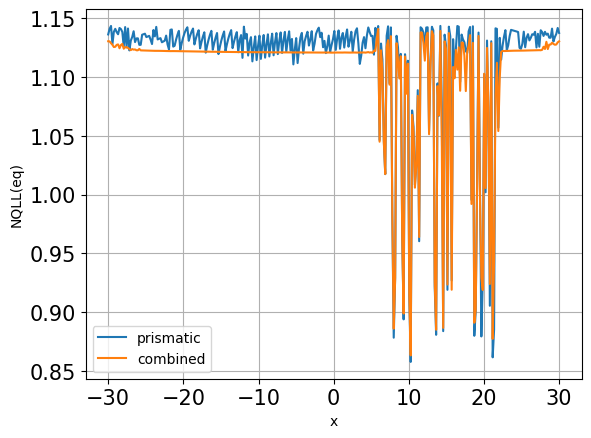

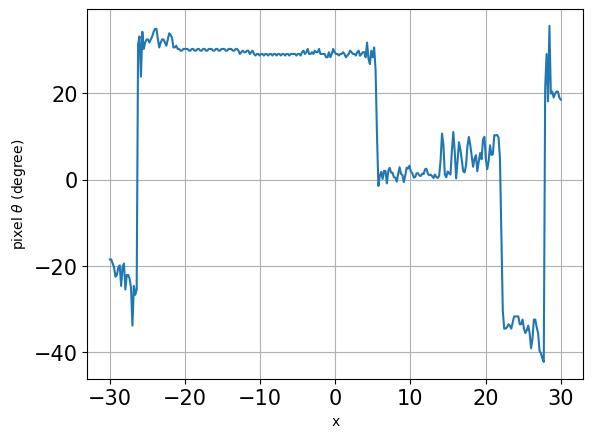

In [19]:
# Probing properties of multiple facet types
itime = -1
print('Probing itime =',itime)
print('Probing time =',tkeep_1Darr[itime].to('millisecond'))
Ntot_pr = Ntotkeep_1D[itime,:]
NQLL_pr = NQLLkeep_1D[itime,:]
xleft = 0
xright = 30

# Specifying how to partition among the three facets
beta_trans = np.sin(theta/2)/np.cos(theta/2)
print('beta_trans =', beta_trans)
delta_beta = beta_trans/beta_trans_factor
print('delta_beta',delta_beta)

# # This is just to get a visual on the partitioning among the three facets (alpha)
# beta = np.linspace(-beta_trans*2,beta_trans*2,500)
# delta_beta = beta_trans/5
# alpha_pyneg = QLC.get_alpha(beta,-beta_trans,delta_beta)
# alpha_pypos = 1-QLC.get_alpha(beta, beta_trans,delta_beta)
# alpha_pr = 1 - alpha_pyneg - alpha_pypos
# plt.figure()
# plt.plot(beta,alpha_pr,label='prismatic')
# plt.plot(beta,alpha_pyneg,label='negative-sloped '+str(theta))
# plt.plot(beta,alpha_pypos,label='positive-sloped '+str(theta))
# plt.xlabel(r'$\beta$')
# plt.ylabel(r'$\alpha$')
# plt.grid(True)
# plt.legend()

# Now we'll work with the Ntot data of interest
h_py = h_pr*h_pyfactor
Ntot_pyneg = 1/h_py * (np.cos(theta)*h_pr* Ntot_pr -np.sin(theta)*x_QLC)
Ntot_pypos = 1/h_py * (np.cos(theta)*h_pr* Ntot_pr +np.sin(theta)*x_QLC)

plt.figure()
plt.plot(x_QLC,Ntot_pr,label='prismatic')
# plt.plot(x_QLC,Ntot_pyneg,label='negative-sloped '+str(theta))
# plt.plot(x_QLC,Ntot_pypos,label='positive-sloped '+str(theta))
plt.xlabel('x')
plt.ylabel('Ntot')
plt.grid(True)
plt.legend()
# plt.xlim([xleft,xright])

z_pr = h_pr * Ntot_pr
dx = x_QLC[1]-x_QLC[0]
beta = np.gradient(z_pr,dx)
beta.ito('dimensionless')
alpha_pyneg = QLC.get_alpha(beta.magnitude,-beta_trans.magnitude,delta_beta.magnitude)
alpha_pypos = 1-QLC.get_alpha(beta.magnitude, beta_trans.magnitude,delta_beta.magnitude)
alpha_pr = 1 - alpha_pyneg - alpha_pypos

plt.figure()
plt.plot(x_QLC,alpha_pr,label='prismatic')
plt.plot(x_QLC,alpha_pyneg,label='negative-sloped '+str(theta))
plt.plot(x_QLC,alpha_pypos,label='positive-sloped '+str(theta))
plt.xlabel('x')
plt.ylabel(r'$\alpha$')
plt.legend()
plt.grid(True)
# plt.xlim([xleft,xright])

Nstar_pr = Nstar
Nstar_py = Nstar_pr*Nstarfactor; print(Nstar_py)
NQLL_eq_pr    = Nbar - Nstar_pr*np.sin(2*np.pi*Ntot_pr)
NQLL_eq_pyneg = Nbar - Nstar_py*np.sin(2*np.pi*Ntot_pyneg)
NQLL_eq_pypos = Nbar - Nstar_py*np.sin(2*np.pi*Ntot_pypos)
NQLL_eq = alpha_pr*NQLL_eq_pr + alpha_pyneg*NQLL_eq_pyneg + alpha_pypos*NQLL_eq_pypos

plt.figure()
plt.plot(x_QLC,NQLL_eq_pr,   label='prismatic')
# plt.plot(x_QLC,NQLL_eq_pyneg,label='negative-sloped '+str(theta))
# plt.plot(x_QLC,NQLL_eq_pypos,label='positive-sloped '+str(theta))
plt.plot(x_QLC,NQLL_eq,label='combined')
plt.xlabel('x')
plt.ylabel('NQLL(eq)')
plt.legend()
plt.grid(True)
# plt.xlim([xleft,xright])

# plt.figure()
# plt.plot(x_QLC,NQLL_eq-NQLL_eq_pr,label='combined-'+str(theta))
# plt.xlabel('x')
# plt.ylabel('NQLL(eq)')
# plt.legend()
# plt.grid(True)
# plt.xlim([xleft,xright])

# slopes = dx.magnitude*np.ones(len(x_QLC)) + 1j*beta.magnitude*dx.magnitude
slopes = np.ones(len(x_QLC)) + 1j*beta.magnitude
angles = AssignQuantity(np.angle(slopes),'radian')
angles.ito('degree')

plt.figure()
if (np.max(np.abs(angles.magnitude)) > 0.01):
    plt.plot(x_QLC,angles.magnitude)
    plt.xlabel('x')
    plt.ylabel(r'pixel $\theta$ ('+str(angles.units)+')')
else:
    plt.plot(x_QLC,angles.magnitude*1000)
    plt.xlabel('x')
    plt.ylabel(r'pixel $\theta$ ('+str(angles.units)+'*1000)')

plt.grid(True)
# plt.xlim([xleft,xright])

# m_actual = (NQLL_pr-(Nbar-Nstar))/(2*Nstar)
# sigma_m_actual = sigmaI_QLC - m_actual * sigma0
# Nstar_est = alpha_pr*Nstar_pr + alpha_pyneg*Nstar_py + alpha_pypos*Nstar_py
# m_predicted = (NQLL_pr -(Nbar-Nstar_est))/(2*Nstar_est)
# sigma_m_predicted = sigmaI_QLC - m_predicted * sigma0

# plt.figure()
# plt.plot(x_QLC,sigma_m_actual*100,label='actual')
# plt.plot(x_QLC,sigma_m_predicted*100,label='predicted')
# plt.xlabel('x')
# plt.ylabel(r'$\sigma_m$ (%)')
# plt.grid(True)
# plt.legend()
# plt.xlim([xleft,xright])